Code to compute Kevin Tory's DWI using projections, from the article Developing simple fire-weather indices using dewpoint depression and windspeed: Application to Australian Eucalypt forests.

Basic formula is: DWI = (DPD + A)/B * (V + C)/D where DPD is the dewpoint depression, V is the wind speed, A, B, C, D are constants defined in the paper. 

As projections to not produce Td, we will have to compute it from temperatue and relative humidity. We will use tasmax and hursmin as we are computing the afternoon approximate fire weather value, other inputs will be needed for fireweather computations at other times of the day. 

Using the formula: Td = 243.5 [ln(rh/100) + 17.67T/(243.5 + T)]/(17.67 – [ln(rh/100) + 17.67T/(243.5 + T)])

The functions will take A, B, C, D as input to be applicable to possible future tunings of the simplified DWI to other fuels. 

In [1]:
import dask
from dask.distributed import Client, wait
from dask import delayed

client = Client(n_workers=7, threads_per_worker=1) 
#client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33387,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:40403,Total threads: 1
Dashboard: /proxy/33843/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:44375,


2025-08-13 16:46:07,070 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='/g/data/ia39/ncra/bushfire/dwi/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/day/ssp370_ACCESS-ESM1-5_BARPA-R_gwl3.0_dwi.nc', lease_id='623ee715743e480bbf0ffe1448133a3e'. This can happen if the Lock or Semaphore timed out before.
2025-08-13 16:47:50,826 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='/g/data/ia39/ncra/bushfire/dwi/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/day/ssp370_ACCESS-ESM1-5_BARPA-R_gwl3.0_dwi.nc', lease_id='c1d30352d59a49bf9736a206d828212a'. This can happen if the Lock or Semaphore timed out before.
2025-08-13 16:48:53,475 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='/g/data/ia39/ncra/bushfire/dwi/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/day/ssp370_ACCESS-ESM1-5_BARPA-R_gwl3.0_dwi.nc', lease_id='892b390383344f9c9292

In [2]:
#import all the stuff
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append("/g/data/mn51/users/nb6195/project/gwls/")
import gwl

In [3]:
#function to calculate dewpoint depression
#inputs: datasets of temperature and relative humidity
#outputs: a dataset of dewpoint depression
def calc_dpd(ds_temp, ds_rh):
    dpd = ds_temp - 243.5 * (np.log(ds_rh/100) + 17.67*ds_temp/(243.5 + ds_temp))/(17.67 - (np.log(ds_rh/100) + 17.67*ds_temp/(243.5 + ds_temp)))

    dpd.attrs = {
        'long_name': 'afternoon dewpoint depression computed from tasmax and hursmin',
        'standard_name': 'dpd',
        'units': 'degC',
        'program' : 'Australian Climate Service (ACS)',
        'summary' : f'Fire weather metric: dewpoint depression for Global Warming Level {chosen_gwl} C',
        'naming_authority' : "Bureau of Meteorology",
        'publisher_type' : "group",
        'publisher_type' : "group" ,
        'publisher_institution' : "Bureau of Meteorology",
        'publisher_name' : "Bureau of Meteorology",
        'publisher_url' : "http://www.bom.gov.au",
        'creator_type' : "institution" ,
        'creator_institution' : "Bureau of Meteorology" ,
        'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
        'institute_id' : "BOM" ,
        'institution' : "Bureau of Meteorology",
#        'regrid_method': 'bilinear'
    }
    ds_dpd = xr.Dataset({'dpd' : dpd})
    ds_rh.close()
    ds_temp.close()
    
    return ds_dpd

In [4]:
def calc_dwi(ds_temp, ds_rh, ds_wind_sp, A, B, C, D):
    dwi = (calc_dpd(ds_temp, ds_rh)['dpd'] + A)/B * (ds_wind_sp + C)/D

    dwi.attrs = {
    'long_name': 'afternoon dry-windy index computed from tasmax, hursmin, maximum wind speed, and the tuned constants',
    'standard_name': 'dwi',
    'units': 'km h-1',
    'program' : 'Australian Climate Service (ACS)',
    'summary' : f'Fire weather metric: Dry-windy index for Global Warming Level {chosen_gwl} C',
    'naming_authority' : "Bureau of Meteorology",
    'publisher_type' : "group",
    'publisher_type' : "group" ,
    'publisher_institution' : "Bureau of Meteorology",
    'publisher_name' : "Bureau of Meteorology",
    'publisher_url' : "http://www.bom.gov.au",
    'creator_type' : "institution" ,
    'creator_institution' : "Bureau of Meteorology" ,
    'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
    'institute_id' : "BOM" ,
    'institution' : "Bureau of Meteorology",
#    'regrid_method': 'bilinear'
#    'acknowledgement' : "Development of data supported with funding from the Australian Climate Service.",
    }
    ds_dwi = xr.Dataset({'dwi' : dwi})
    ds_rh.close()
    ds_temp.close()
    ds_wind_sp.close()
    return ds_dwi

In [5]:
#conversion factor to FFDI from Kevin
#Psudo FFDI: (50/3)*(DF/10) matching FFDI for a particular event provided by Musa, 30 Sept 2023
#also computed for mean T humidity for Melb airport for Feb for total obs history at that time
#this removes the wind speed bias - FFDI undersensitive to wind and over sensitive to temp, 
#they often compensate. But not great on cool windy days
def calc_p_ffdi(ds_dwi):
    p_ffdi = 50/3*ds_dwi

    p_ffdi.attrs = {
    'long_name': 'Psudo FFDI computed from tasmax, hursmin, maximum wind speed, and the tuned constants',
    'standard_name': 'p_ffdi',
    #'units': 'km h-1',
    'program' : 'Australian Climate Service (ACS)',
    'summary' : f'Fire weather metric: p_ffdi for Global Warming Level {chosen_gwl} C',
    'naming_authority' : "Bureau of Meteorology",
    'publisher_type' : "group",
    'publisher_type' : "group" ,
    'publisher_institution' : "Bureau of Meteorology",
    'publisher_name' : "Bureau of Meteorology",
    'publisher_url' : "http://www.bom.gov.au",
    'creator_type' : "institution" ,
    'creator_institution' : "Bureau of Meteorology" ,
    'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
    'institute_id' : "BOM" ,
    'institution' : "Bureau of Meteorology",
#    'regrid_method': 'bilinear'
#    'acknowledgement' : "Development of data supported with funding from the Australian Climate Service.",
    }
    ds_p_ffdi = xr.Dataset({'p_ffdi' : p_ffdi})
    ds_dwi.close()
    return ds_p_ffdi

In [6]:
#conversion factor to FFDI from Kevin
#Faux FFDI: (T + 12)(DF/10)/2 

def calc_faux_ffdi(ds_dwi, ds_temp):
    faux_ffdi = (ds_temp + 12)*ds_dwi/2

    faux_ffdi.attrs = {
    'long_name': 'Faux FFDI computed from tasmax, hursmin, maximum wind speed, and the tuned constants',
    'standard_name': 'faux_ffdi',
    #'units': 'km h-1',
    'program' : 'Australian Climate Service (ACS)',
    'summary' : f'Fire weather metric: faux_ffdi for Global Warming Level {chosen_gwl} C',
    'naming_authority' : "Bureau of Meteorology",
    'publisher_type' : "group",
    'publisher_type' : "group" ,
    'publisher_institution' : "Bureau of Meteorology",
    'publisher_name' : "Bureau of Meteorology",
    'publisher_url' : "http://www.bom.gov.au",
    'creator_type' : "institution" ,
    'creator_institution' : "Bureau of Meteorology" ,
    'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
    'institute_id' : "BOM" ,
    'institution' : "Bureau of Meteorology",
#    'regrid_method': 'bilinear'
#    'acknowledgement' : "Development of data supported with funding from the Australian Climate Service.",
    }
    ds_faux_ffdi = xr.Dataset({'faux_ffdi' : faux_ffdi})
    ds_temp.close()
    ds_dwi.close()
    return ds_faux_ffdi

BOM done:
- CESM2
- CMCC-ESM2
- NorESM2-MM

BOM to-do:

- MPI-ESM1-2-HR (r1i1p1f1)
- EC-Earth3 (r1i1p1f1)
- ACCESS-CM2 (r4i1p1f1)
- ACCESS-ESM1-5 (r6i1p1f1)

CSIRO done:
- CESM2
- CMCC-ESM2
- NorESM2-MM
- ACCESS-ESM1-5 (r6i1p1f1)

CSIRO to-do:

- CNRM-ESM2-1 (r1i1p1f2)
- EC-Earth3
- ACCESS-CM2 (r4i1p1f1)

In [7]:
#Set parameters
CMIP='CMIP6'
#AGENCY = 'CSIRO' 
#RCM = 'CCAM-v2203-SN'
AGENCY = 'BOM' 
RCM = 'BARPA-R'

#GCM = 'ACCESS-CM2' #ensemble = 'r4i1p1f1' #Done
GCM = 'ACCESS-ESM1-5' 
ensemble = 'r6i1p1f1' #Done
#GCM = 'EC-Earth3' ensemble = 'r1i1p1f1' #Done
#GCM = 'MPI-ESM1-2-HR' ensemble = 'r1i1p1f1' #BOM done, no CSIRO
#GCM = 'CESM2' ensemble = 'r11i1p1f1' #Done
#GCM = 'CMCC-ESM2' ensemble = 'r1i1p1f1' #Done
#GCM = 'NorESM2-MM' ensemble = 'r1i1p1f1' #Done
#GCM = 'CNRM-ESM2-1' ensemble = 'r1i1p1f2' #CSIRO Done, no BOM

#pathway = 'ssp126'
pathway = 'ssp370'

ddir = f"/g/data/kj66/CORDEX/output/{CMIP}/DD/AUST-05i/{AGENCY}/{GCM}"
output_dir = '/g/data/ia39/ncra/bushfire/dwi/'
#output_dir_mm = '/g/data/ia39/ncra/bushfire/dwi/monthly_mean/'

In [8]:
#read in RCM files
var1 = 'tasmax'
infiles1a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles1b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
tasmax_master_ds = xr.open_mfdataset(infiles1a + infiles1b)

In [9]:
var2 = 'hursmin'
infiles2a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles2b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
hursmin_master_ds = xr.open_mfdataset(infiles2a + infiles2b)

In [10]:
var3 = 'sfcWindmax'
infiles3a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles3b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
wind_sp_master_ds = xr.open_mfdataset(infiles3a + infiles3b)

In [11]:
#Vesta DWI: fire spread rate, expect up to 10% of wind speed in 
#extreme conditions (very dry M. Cruz results).
#Values here from the paper provide an excellent approximation for 
#windspeeds between 10 and 80 km\ h^{-1}, using the longest unburned 
#fuel settings (10+ years) provided in Table 6 of Cheney et al. (2012).  
A = 5
B = 20
C = 0
D = 25

In [12]:
#Extract time period corresponding to the chosen GWL for tasmax and rh
chosen_gwl = '3.0'

gwl_tasmax = gwl.get_GWL_timeslice(tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
gwl_rh = gwl.get_GWL_timeslice(hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
gwl_wind_sp = gwl.get_GWL_timeslice(wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

In [13]:
#function testing
gwl_dwi = calc_dwi(gwl_tasmax, gwl_rh, gwl_wind_sp, A, B, C, D)

In [14]:
gwl_dwi

<xarray.DataArray (time: 7305, lat: 691, lon: 886)> Size: 18GB
dask.array<truediv, shape=(7305, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 58kB 2062-01-01T12:00:00 ... 2081-12-31T12...
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Attributes: (12/15)
    long_name:              afternoon dry-windy index computed from tasmax, h...
    standard_name:          dwi
    units:                  km h-1
    program:                Australian Climate Service (ACS)
    summary:                Fire weather metric: Dry-windy index for Global W...
    naming_authority:       Bureau of Meteorology
    ...                     ...
    publisher_url:          http://www.bom.gov.au
    creator_type:           institution
    creator_institution:    Bureau of Meteorology
    contact:                Naomi Benger (naomi.benger@bom.gov.au)
    institute_id:           BOM
    institution:            Bureau of Meteorology

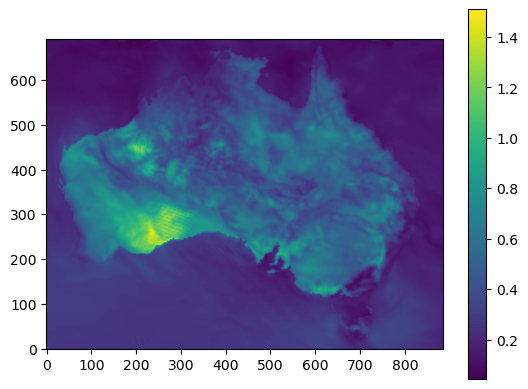

In [15]:
plt.imshow(gwl_dwi[1], origin='lower')
plt.colorbar()

In [19]:
file_name_dwi = pathway + '_' + GCM + '_' + RCM + '_gwl' + chosen_gwl + '_dwi.nc'
output_file_location = output_dir + GCM + '/' + pathway + '/' + ensemble + '/' + RCM + '/v1-r1/day/' + file_name_dwi
gwl_dwi.to_netcdf(output_file_location, engine='netcdf4')
print(output_file_location)

/g/data/ia39/ncra/bushfire/dwi/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/day/ssp370_ACCESS-ESM1-5_BARPA-R_gwl3.0_dwi.nc


In [20]:
gwl_p_ffdi = calc_p_ffdi(gwl_dwi)

In [21]:
file_name_p_ffdi = pathway + '_' + GCM + '_' + RCM + '_gwl' + chosen_gwl + '_p_ffdi.nc'
output_file_location = output_dir + GCM + '/' + pathway + '/' + ensemble + '/' + RCM + '/v1-r1/day/' + file_name_p_ffdi
gwl_p_ffdi.to_netcdf(output_file_location, engine='netcdf4')
print(output_file_location)

/g/data/ia39/ncra/bushfire/dwi/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/day/ssp370_ACCESS-ESM1-5_BARPA-R_gwl3.0_p_ffdi.nc


In [22]:
gwl_faux_ffdi = calc_faux_ffdi(gwl_dwi, gwl_tasmax)

In [24]:
file_name_faux_ffdi = pathway + '_' + GCM + '_' + RCM + '_gwl' + chosen_gwl + '_faux_ffdi.nc'
output_file_location = output_dir + GCM + '/' + pathway + '/' + ensemble + '/' + RCM + '/v1-r1/day/' + file_name_faux_ffdi
gwl_faux_ffdi.to_netcdf(output_file_location, engine='netcdf4')
print(output_file_location)

/g/data/ia39/ncra/bushfire/dwi/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/day/ssp370_ACCESS-ESM1-5_BARPA-R_gwl3.0_faux_ffdi.nc


In [ ]:
#print half files for gwl_vpd
halves = ['1st', '2nd']
#halves = ['2nd']

for half in halves:
    print(half)
    if half == '1st':
        gwl_dwi_print = gwl_dwi[0:3700]
    else: 
        gwl_dwi_print = gwl_dwi[3700:]
        
    file_name_dwi = half + '_' + pathway + '_' + GCM + '_' + RCM + '_gwl' + chosen_gwl + '_dwi.nc'
    output_file_location = output_dir + GCM + '/' + pathway + '/' + ensemble + '/' + RCM + '/v1-r1/day/' + file_name_dwi
    gwl_dwi_print.to_netcdf(output_file_location, engine='netcdf4')
        
    print('half done')
    print(output_file_location)

In [ ]:
#DWI-based FWI approximating Vesta Mk 2, is comprised of two DWIs with a 
#linear transition between them 